# Extracting HSV histograms

We look at computing the HSV histogram on images using OpenCV

In [31]:
import os
import cv2
import csv
from pylab import *
import scipy
import scipy.misc
from PIL import Image
from scipy.stats.mstats import mode
from skimage.util.shape import view_as_blocks, view_as_windows
%matplotlib inline

In [2]:
# path to our sample image
#image_path = "./france.jpg"
image_path = "/Users/myazdaniUCSD/Documents/paintings/scripts/color_features/france.jpg"

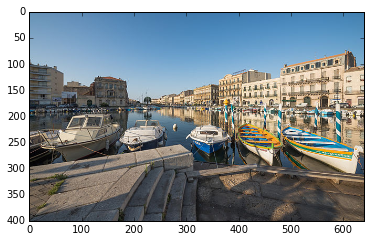

In [3]:
# here the image is loaded using OpenCV
im = cv2.imread(image_path)
imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

# Computing HSV histogram

/Users/myazdaniUCSD/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


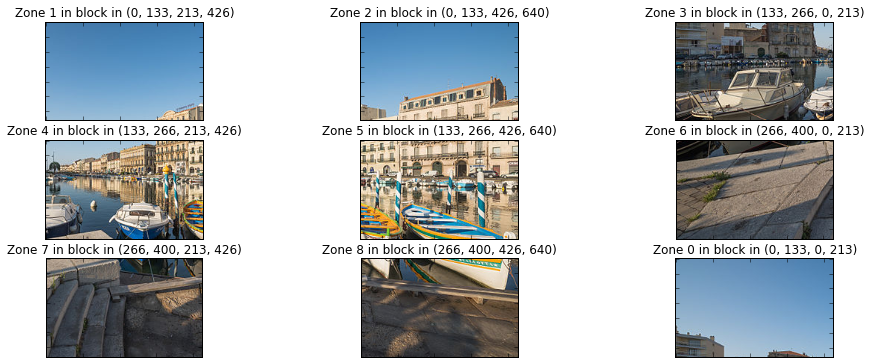

In [4]:
fig = figure(figsize=(16,6), dpi=100)
im = Image.open(image_path)
num_blocks = 3
step_x = im.size[1]/num_blocks
step_y = im.size[0]/num_blocks
subfigure_counter = 0
block_index = 0
for i in range(num_blocks):
    for j in range(num_blocks):
        ax = subplot(num_blocks,num_blocks,subfigure_counter)
        subfigure_counter += 1
        # set starting and ending indices for row blocks
        if i < (num_blocks-1): 
            start_x, end_x = i*step_x, (i+1)*step_x
        # deal with the edge case row blocks
        else:
            start_x, end_x = i*step_x, im.size[1]
        # set starting and ending indices for vertical blocks
        if j < (num_blocks-1):
            start_y, end_y = j*step_y, (j+1)*step_y
        # deal with the edge case vertical blocks
        else:
            start_y, end_y = j*step_y, im.size[0]
        box = (start_y, start_x, end_y, end_x)
        im_block = im.crop(box) 
        imshow(array(im_block))
        title("Zone %d in block in (%d, %d, %d, %d) " % (block_index, start_x, end_x, start_y, end_y))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        block_index += 1

In [5]:
def HSVhist_cv(im_path, num_blocks, channels = range(3)):
    # read image
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    if str(type(im)) == "<type 'NoneType'>":
        return None
    # set block step sizes
    step_x = im.shape[0]/num_blocks
    step_y = im.shape[1]/num_blocks
    print im.shape
    hists = {}
    hists_key = {}
    block_index = 0
    for i in range(num_blocks):
            for j in range(num_blocks):
                # set starting and ending indices for row blocks
                if i < (num_blocks-1): 
                    start_x, end_x = i*step_x, (i+1)*step_x
                # deal with the edge case row blocks
                else:
                    start_x, end_x = i*step_x, im.shape[0]
                # set starting and ending indices for vertical blocks
                if j < (num_blocks-1):
                    start_y, end_y = j*step_y, (j+1)*step_y
                # deal with the edge case vertical blocks
                else:
                    start_y, end_y = j*step_y, im.shape[1]    
                #copy image into block
                im_block = im[start_x:end_x, start_y:end_y,:].copy()
                hist_channels = []
                if type(channels) == int:
                    if channels == 0:
                        hist_temp = cv2.calcHist([im_block],[channels],None,[180],[0,180])
                        hist_channels.append(hist_temp/(max(hist_temp)+1.0))
                    else:
                        hist_temp = cv2.calcHist([im_block],[channels],None,[256],[0,256])
                        hist_channels.append(hist_temp/(max(hist_temp)+1.0))   
                else:                   
                    for channel in channels: 
                        if channel == 0:
                            hist_temp = cv2.calcHist([im_block],[channel],None,[180],[0,180])
                            hist_channels.append(hist_temp/(max(hist_temp)+1.0))
                        else:
                            hist_temp = cv2.calcHist([im_block],[channel],None,[256],[0,256])
                            hist_channels.append(hist_temp/(max(hist_temp)+1.0))
                hists[block_index] = hist_channels
                hists_key[block_index] = (start_x, end_x, start_y, end_y)
                block_index += 1
    return hists, hists_key

(400, 640, 3)


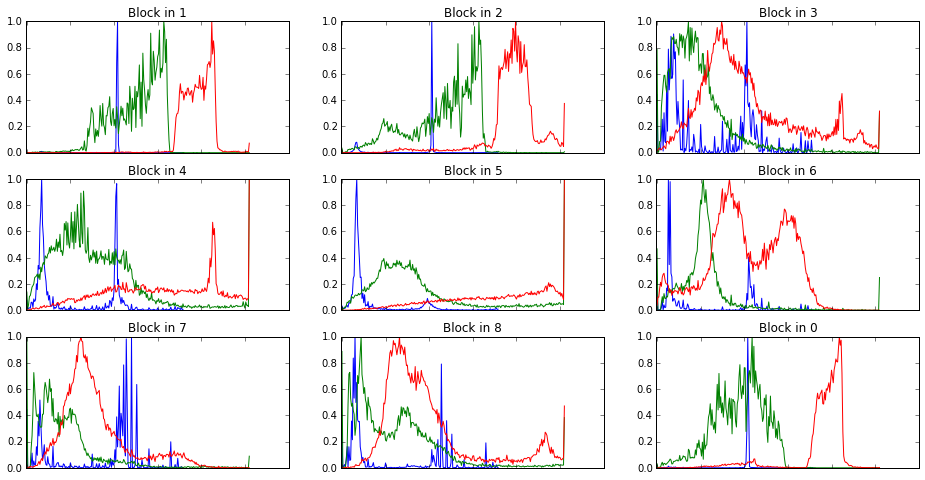

In [6]:
# display color histogram 
fig = figure(figsize=(16,8), dpi=100)
hists, hists_key = HSVhist_cv(image_path, 3)
color = ('b','g','r')
for i, key in enumerate(hists.keys()):
    ax = subplot(3,3,i)
    for k,col in enumerate(color):
        plot(hists[key][k],color = col) 
        xlim([-1,300])
        title("Block in " + str(key))
        ax.set_xticklabels([])

In [7]:
hists.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8]

# Compute dominant color in each zone using mode

In [8]:
dom_HSVs = {}
for i, key in enumerate(hists.keys()):
    zone_hists = hists[key] 
    dom_hsv = zeros((100,100,3))
    for k, zone_hist in enumerate(zone_hists):
        dom_hsv[:,:,k] = uint8(argmax(zone_hist))*ones(100)
    dom_HSVs[key] = array(dom_hsv, dtype = uint8)
        

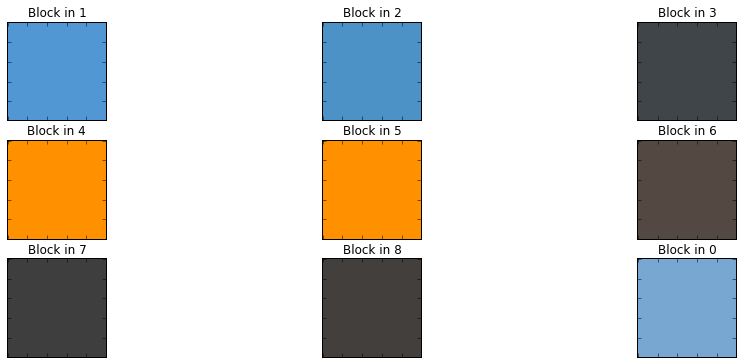

In [9]:
fig = figure(figsize=(16,6), dpi=100)
for i, key in enumerate(dom_HSVs):
    ax = subplot(3,3,i)
    imshow(cv2.cvtColor(dom_HSVs[key], cv2.COLOR_HSV2RGB))
    title("Block in " + str(key))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Compute dominant color in each zone using median

In [53]:
def HSVavg_cv(im_path, num_blocks, channels = range(3)):
    # read image
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    if str(type(im)) == "<type 'NoneType'>":
        return None
    # set block step sizes
    step_x = im.shape[0]/num_blocks
    step_y = im.shape[1]/num_blocks
    dom_HSVs = {}
    dom_HSVs_key = {}
    block_index = 0
    for i in range(num_blocks):
            for j in range(num_blocks):
                # set starting and ending indices for row blocks
                if i < (num_blocks-1): 
                    start_x, end_x = i*step_x, (i+1)*step_x
                # deal with the edge case row blocks
                else:
                    start_x, end_x = i*step_x, im.shape[0]
                # set starting and ending indices for vertical blocks
                if j < (num_blocks-1):
                    start_y, end_y = j*step_y, (j+1)*step_y
                # deal with the edge case vertical blocks
                else:
                    start_y, end_y = j*step_y, im.shape[1]    
                #copy image into block
                im_block = im[start_x:end_x, start_y:end_y,:].copy()
                hsv_channels = []
                #for channel in channels: hsv_channels.append(round(mode(im_block[:,:,channel], axis = None)[0]))
                for channel in channels: hsv_channels.append(round(median(im_block[:,:,channel])))
                dom_HSVs[block_index] = hsv_channels
                dom_HSVs_key[block_index] = (start_x, end_x, start_y, end_y)
                block_index += 1
    return dom_HSVs, dom_HSVs_key

In [54]:
avgHSVs, avgKey = HSVavg_cv(image_path, 3)
dom_HSVs = {}
for i, key in enumerate(avgKey.keys()):
    zone_hists = avgHSVs[key] 
    dom_hsv = zeros((100,100,3))
    for k, zone_hist in enumerate(zone_hists):
        dom_hsv[:,:,k] = uint8(zone_hist)*ones(100)
    dom_HSVs[key] = array(dom_hsv, dtype = uint8)

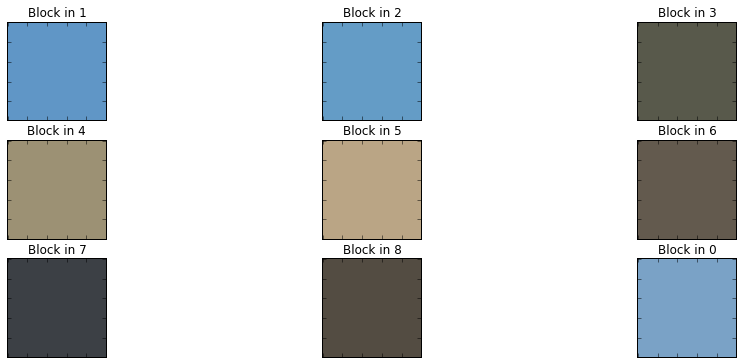

In [55]:
fig = figure(figsize=(16,6), dpi=100)
for i, key in enumerate(dom_HSVs):
    ax = subplot(3,3,i)
    imshow(cv2.cvtColor(dom_HSVs[key], cv2.COLOR_HSV2RGB))
    title("Block in " + str(key))
    ax.set_xticklabels([])
    ax.set_yticklabels([])